# Import the modules 

In [7]:
# import the general modules
from optlang.symbolics import Zero
from itertools import combinations
from matplotlib import pyplot
from numpy import unique
import networkx
import cobra
import cplex
import sys
import re
import os

# import kbase

os.environ["HOME"] = 'C:\\Users\\Andrew Freiburger\\Dropbox\\My PC (DESKTOP-M302P50)\\Documents\\UVic Civil Engineering\\Internships\\Agronne\\cobrakbase'
import cobrakbase
token = 'I6WL7MAW5Z4QO3OQ62YUR6HJM6RAUFHE'
kbase = cobrakbase.KBaseAPI(token)

# import modelseedpy packages
from modelseedpy import KBaseMediaPkg
from modelseedpy.fbapkg import fullthermopkg, elementuptakepkg


# Define the CommunityFBA function

In [3]:
def communityFBA(modelInfo,mediaInfo,kinetic_coeff,abundances=None):
    # import the model and media
    model = kbase.get_from_ws(modelInfo[0],modelInfo[1])
    media = kbase.get_from_ws(mediaInfo[0],mediaInfo[1])
    kmp = KBaseMediaPkg(model)
    kmp.build_package(media)
    model.solver = 'optlang-cplex'
    
    # applying uptake limit to total carbon uptake by model
    '''eup = elementuptakepkg.ElementUptakePkg(model)
    eup.build_package({"C":60})
    '''
    
    # applying community model kinetic constraints
    '''ckp = CommKineticPkg(model)
    ckp.build_package(kinetic_coeff,abundances)
    '''

    # unambiguously define the model objective 
    biomass_objective = model.problem.Objective(
        1 * model.reactions.bio1.flux_expression,
        direction='max')
    model.objective = biomass_objective

    # excute FBA
    solution = model.optimize()
    display(model.summary())
    '''pfba_solution = cobra.flux_analysis.pfba(model)'''
    
    # calculate the metabolic exchanges
    metabolite_uptake = {}
    compartment_numbers = []
    for rxn in model.reactions:
        if (rxn.id[-2] == 'c' or rxn.id[-2] == 'p') and rxn.id[-1] != '0':
            compartment_number = rxn.id[-1]
            '''print(compartment_number, '\t', rxn.id)'''
            compartment_numbers.append(compartment_number)
            '''else:
                print('--->', compartment_number, '\t', rxn.id)'''

            for metabolite in rxn.metabolites:
                if metabolite.compartment == "e0":
                    rate_law = 0
                    flux = solution.fluxes[rxn.id]
                    if flux != 0:
                        rate_law += rxn.metabolites[metabolite]*flux
                        metabolite_uptake[(metabolite.id,compartment_number)] = rate_law

    compartment_numbers = unique(compartment_numbers)
    number_of_compartments = len(compartment_numbers)

    # cross feeding of extracellular metabolites amongst the community members
    cross_all = []
    for rxn in model.reactions:
        for metabolite in rxn.metabolites:
            if metabolite.compartment == "e0":
                # determine each directional flux rate 
                rate_out = {compartment_number: rate for (metabolite_id, compartment_number), rate in metabolite_uptake.items() if metabolite_id == metabolite.id and rate > 0}
                rate_in = {compartment_number: -rate for (metabolite_id, compartment_number), rate in metabolite_uptake.items() if metabolite_id == metabolite.id and -rate > 0}

                # determine total directional flux rate 
                total_in = sum(rate_in.values())
                total_out = sum(rate_out.values())
                max_total_rate = max(total_in, total_out)

                # determine net flux 
                if total_in > total_out:
                    rate_out[None] = total_in - total_out
                if total_in < total_out:
                    rate_in[None] = total_out - total_in

                # establish the metabolites that partake in cross feeding 
                cross = [(o1, o2, metabolite, r1 * r2 / max_total_rate) for o1, r1 in rate_out.items() for o2, r2 in rate_in.items()]
                cross_all.extend(cross) # [donor, receiver, compound, rate]

    '''for i in cross_all:
        print(i)'''

    # establish the production and consumption of nutrients in each compartment
    production = [[0] * number_of_compartments for i in range(number_of_compartments)] #production[donorSpecies][receiverSpecies]
    consumption = [[0] * number_of_compartments for i in range(number_of_compartments)]

    for i in cross_all:
        if i[0] is not None and i[1] is not None:
            production[int(i[0])-1][int(i[1])-1] += i[3]
            consumption[int(i[1])-1][int(i[0])-1] += i[3]

    # graph the resultant community interaction
    graph = networkx.Graph()
    for i in compartment_numbers:
        graph.add_node(i)
    for k in combinations(compartment_numbers, 2):
        sp1 = int(k[0])-1
        sp2 = int(k[1])-1
        if production[sp1][sp2] > consumption[sp2][sp1]:
            interaction_flux = production[sp1][sp2]
        else:
            interaction_flux = consumption[sp2][sp1]
        graph.add_edge(k[0],k[1],weight=interaction_flux)

    pos = networkx.circular_layout(graph)
    networkx.draw_networkx(graph,pos)
    labels = networkx.get_edge_attributes(graph,'weight')
    networkx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)

# The 2-member Zahmeeth model

## Unconstained model

### Define and execute the model

Metabolite,Reaction,Flux,C-Number,C-Flux
cpd00009_e0,EX_cpd00009_e0,0.2375,0,0.00%
cpd00013_e0,EX_cpd00013_e0,1.933,0,0.00%
cpd00027_e0,EX_cpd00027_e0,5,6,99.86%
cpd00028_e0,EX_cpd00028_e0,0.0004055,34,0.05%
cpd00030_e0,EX_cpd00030_e0,0.0004656,0,0.00%
cpd00034_e0,EX_cpd00034_e0,0.0004352,0,0.00%
cpd00048_e0,EX_cpd00048_e0,0.0003769,0,0.00%
cpd00058_e0,EX_cpd00058_e0,6.159E-05,0,0.00%
cpd00063_e0,EX_cpd00063_e0,0.0008577,0,0.00%
cpd00098_e0,EX_cpd00098_e0,0.0004055,5,0.01%


1
2


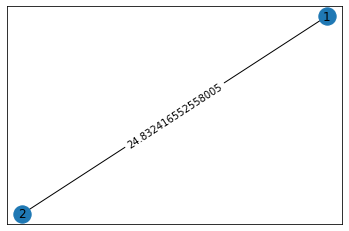

In [5]:
# execute the model and media through the afore-defined function
modelInfo_2 = ["CMM_iAH991V2_iML1515.kb",40576]
mediaInfo_2 = ["Btheta_Ecoli_minimal_media",40576]
communityFBA(modelInfo_2,mediaInfo_2,2100,{"1":0.5,"2":0.5})

## FullThermo-constrained model

### Constrain the model

In [ ]:
# import the model and media
'''model = kbase.get_from_ws('CMM_iAH991V2_iML1515.kb',40576)
media = kbase.get_from_ws("Btheta_Ecoli_minimal_media",40576)
kmp = KBaseMediaPkg(model)
kmp.build_package(media)'''

# implement FullThermo
'''modelseed_db_path = '..\..\..\Biofilm growth code\GSWL code\ModelSEEDDatabase'
ftp = fullthermopkg.FullThermoPkg(model)
ftp.build_package({'modelseed_path':modelseed_db_path})'''

# export the constraint model back to KBase
'''kbase.save_object('CMM_iAH991V2_iML1515_FullThermo.kb', 'freiburgermsu:narrative_1624557251879', 'KBaseFBA.FBAModel', model) # saving the object back to KBase with id=E_iAH991V2 to the workspace freiburgermsu:narrative_1624557251879 assigning this type KBaseFBA.FBAModel and with data=object_json'''

# export the constrained LP file 
'''with open('FullThermo.lp', 'w') as out:
    out.write(str(model.solver))'''

### Define and execute the model

Metabolite,Reaction,Flux,C-Number,C-Flux
cpd00009_e0,EX_cpd00009_e0,0.2375,0,0.00%
cpd00013_e0,EX_cpd00013_e0,1.933,0,0.00%
cpd00027_e0,EX_cpd00027_e0,5,6,99.86%
cpd00028_e0,EX_cpd00028_e0,0.0004055,34,0.05%
cpd00030_e0,EX_cpd00030_e0,0.0004656,0,0.00%
cpd00034_e0,EX_cpd00034_e0,0.0004352,0,0.00%
cpd00048_e0,EX_cpd00048_e0,0.0003769,0,0.00%
cpd00058_e0,EX_cpd00058_e0,6.159E-05,0,0.00%
cpd00063_e0,EX_cpd00063_e0,0.0008577,0,0.00%
cpd00098_e0,EX_cpd00098_e0,0.0004055,5,0.01%


1
2


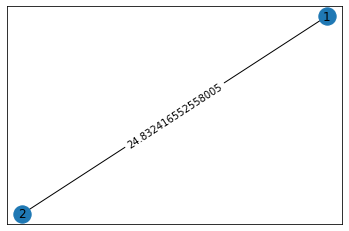

In [15]:
# execute the model and media through the afore-defined function
modelInfo_2 = ['CMM_iAH991V2_iML1515_FullThermo.kb',93832]
mediaInfo_2 = ["Btheta_Ecoli_minimal_media",40576]
communityFBA(modelInfo_2,mediaInfo_2,2100,{"1":0.5,"2":0.5})

# The 3-member model

## Unconstrained model

### Define and execute the model

Metabolite,Reaction,Flux,C-Number,C-Flux
cpd00013_e0,EX_cpd00013_e0,33.31,0,0.00%
cpd00030_e0,EX_cpd00030_e0,0.01608,0,0.00%
cpd00034_e0,EX_cpd00034_e0,0.01608,0,0.00%
cpd00048_e0,EX_cpd00048_e0,0.8386,0,0.00%
cpd00058_e0,EX_cpd00058_e0,0.01608,0,0.00%
cpd00063_e0,EX_cpd00063_e0,0.01608,0,0.00%
cpd00099_e0,EX_cpd00099_e0,0.01608,0,0.00%
cpd00149_e0,EX_cpd00149_e0,0.01608,0,0.00%
cpd00205_e0,EX_cpd00205_e0,0.01608,0,0.00%
cpd00254_e0,EX_cpd00254_e0,0.01608,0,0.00%


1
2
3


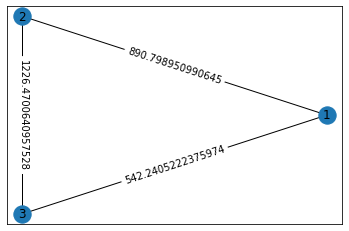

In [12]:
# execute the model and media through the afore-defined function
modelInfo_2 = ['electrosynth_comnty.mdl.gf.2021',93204]
mediaInfo_2 = ["CO2_minimal",93204]
communityFBA(modelInfo_2,mediaInfo_2,2100)

## FullThermo-constrained model

### Constrain the model

In [13]:
# import the model and media
model = kbase.get_from_ws('electrosynth_comnty.mdl.gf.2021',93204)
media = kbase.get_from_ws("CO2_minimal",93204)
kmp = KBaseMediaPkg(model)
kmp.build_package(media)

# implement FullThermo 
modelseed_db_path = '..\..\..\Biofilm growth code\GSWL code\ModelSEEDDatabase'
ftp = fullthermopkg.FullThermoPkg(model)
ftp.build_package({'modelseed_path':modelseed_db_path})

# export the constraint model back to KBase
kbase.save_object('electrosynth_comnty_FullThermo.mdl.gf.2021', 'freiburgermsu:narrative_1624557251879', 'KBaseFBA.FBAModel', model) # saving the object back to KBase with id=E_iAH991V2 to the workspace freiburgermsu:narrative_1624557251879 assigning this type KBaseFBA.FBAModel and with data=object_json

# export the constrained LP file 
'''with open('FullThermo.lp', 'w') as out:
    out.write(str(model.solver))'''

cpd11416_c0 has modelseed ID cpd11416 but does not have a valid deltaG!
cpd11440_c1 has modelseed ID cpd11440 but does not have a valid deltaG!
cpd11441_c1 has modelseed ID cpd11441 but does not have a valid deltaG!
cpd15744_c1 has modelseed ID cpd15744 but does not have a valid deltaG!
cpd15735_c1 has modelseed ID cpd15735 but does not have a valid deltaG!
cpd17042_c1 has modelseed ID cpd17042 but does not have a valid deltaG!
cpd15721_c1 has modelseed ID cpd15721 but does not have a valid deltaG!
cpd15727_c1 has modelseed ID cpd15727 but does not have a valid deltaG!
cpd15317_c1 has modelseed ID cpd15317 but does not have a valid deltaG!
cpd15237_c1 has modelseed ID cpd15237 but does not have a valid deltaG!
cpd11576_e0 has modelseed ID cpd11576 but does not have a valid deltaG!
cpd11576_c1 has modelseed ID cpd11576 but does not have a valid deltaG!
cpd04097_c1 has modelseed ID cpd04097 but does not have a valid deltaG!
cpd04097_e0 has modelseed ID cpd04097 but does not have a valid 

cpd15321_c1 has modelseed ID cpd15321 but does not have a valid deltaG!
cpd15676_c1 has modelseed ID cpd15676 but does not have a valid deltaG!
cpd03834_c1 has modelseed ID cpd03834 but does not have a valid deltaG!
cpd03839_c1 has modelseed ID cpd03839 but does not have a valid deltaG!
cpd08372_c1 has modelseed ID cpd08372 but does not have a valid deltaG!
cpd15399_c1 has modelseed ID cpd15399 but does not have a valid deltaG!
cpd03422_c1 has modelseed ID cpd03422 but does not have a valid deltaG!
cpd11529_c1 has modelseed ID cpd11529 but does not have a valid deltaG!
cpd11530_c1 has modelseed ID cpd11530 but does not have a valid deltaG!
cpd11531_c1 has modelseed ID cpd11531 but does not have a valid deltaG!
cpd15346_c1 has modelseed ID cpd15346 but does not have a valid deltaG!
cpd15661_c1 has modelseed ID cpd15661 but does not have a valid deltaG!
cpd15667_c1 has modelseed ID cpd15667 but does not have a valid deltaG!
cpd15338_c1 has modelseed ID cpd15338 but does not have a valid 

cpd11440_c2 has modelseed ID cpd11440 but does not have a valid deltaG!
cpd11441_c2 has modelseed ID cpd11441 but does not have a valid deltaG!
cpd11527_c2 has modelseed ID cpd11527 but does not have a valid deltaG!
cpd11528_c2 has modelseed ID cpd11528 but does not have a valid deltaG!
cpd11466_c2 has modelseed ID cpd11466 but does not have a valid deltaG!
cpd11493_c2 has modelseed ID cpd11493 but does not have a valid deltaG!
cpd17042_c2 has modelseed ID cpd17042 but does not have a valid deltaG!
cpd15269_c2 has modelseed ID cpd15269 but does not have a valid deltaG!
cpd15349_c2 has modelseed ID cpd15349 but does not have a valid deltaG!
cpd15541_c2 has modelseed ID cpd15541 but does not have a valid deltaG!
cpd15688_c2 has modelseed ID cpd15688 but does not have a valid deltaG!
cpd15694_c2 has modelseed ID cpd15694 but does not have a valid deltaG!
cpd15721_c2 has modelseed ID cpd15721 but does not have a valid deltaG!
cpd15727_c2 has modelseed ID cpd15727 but does not have a valid 

cpd15366_c2 has modelseed ID cpd15366 but does not have a valid deltaG!
cpd15569_c2 has modelseed ID cpd15569 but does not have a valid deltaG!
cpd15684_c2 has modelseed ID cpd15684 but does not have a valid deltaG!
cpd15690_c2 has modelseed ID cpd15690 but does not have a valid deltaG!
cpd11481_c2 has modelseed ID cpd11481 but does not have a valid deltaG!
cpd11485_c2 has modelseed ID cpd11485 but does not have a valid deltaG!
cpd15510_c2 has modelseed ID cpd15510 but does not have a valid deltaG!
cpd12847_c2 has modelseed ID cpd12847 but does not have a valid deltaG!
cpd15603_c2 has modelseed ID cpd15603 but does not have a valid deltaG!
cpd00110_c2 has modelseed ID cpd00110 but does not have a valid deltaG!
cpd00109_c2 has modelseed ID cpd00109 but does not have a valid deltaG!
cpd15521_c2 has modelseed ID cpd15521 but does not have a valid deltaG!
cpd15417_c2 has modelseed ID cpd15417 but does not have a valid deltaG!
cpd11517_c2 has modelseed ID cpd11517 but does not have a valid 

cpd15268_c2 has modelseed ID cpd15268 but does not have a valid deltaG!
cpd15747_c2 has modelseed ID cpd15747 but does not have a valid deltaG!
cpd15765_c2 has modelseed ID cpd15765 but does not have a valid deltaG!
cpd12072_c2 has modelseed ID cpd12072 but does not have a valid deltaG!
cpd12139_c2 has modelseed ID cpd12139 but does not have a valid deltaG!
cpd15725_c2 has modelseed ID cpd15725 but does not have a valid deltaG!
cpd15398_c2 has modelseed ID cpd15398 but does not have a valid deltaG!
cpd15703_c2 has modelseed ID cpd15703 but does not have a valid deltaG!
cpd01476_c2 has modelseed ID cpd01476 but does not have a valid deltaG!
cpd00028_c2 has modelseed ID cpd00028 but does not have a valid deltaG!
cpd11581_c2 has modelseed ID cpd11581 but does not have a valid deltaG!
cpd15751_c2 has modelseed ID cpd15751 but does not have a valid deltaG!
cpd15769_c2 has modelseed ID cpd15769 but does not have a valid deltaG!
cpd15274_c2 has modelseed ID cpd15274 but does not have a valid 

cpd03917_c3 has modelseed ID cpd03917 but does not have a valid deltaG!
cpd03919_c3 has modelseed ID cpd03919 but does not have a valid deltaG!
cpd11472_c3 has modelseed ID cpd11472 but does not have a valid deltaG!
cpd11490_c3 has modelseed ID cpd11490 but does not have a valid deltaG!
cpd15529_c3 has modelseed ID cpd15529 but does not have a valid deltaG!
cpd11526_c3 has modelseed ID cpd11526 but does not have a valid deltaG!
cpd11514_c3 has modelseed ID cpd11514 but does not have a valid deltaG!
cpd11515_c3 has modelseed ID cpd11515 but does not have a valid deltaG!
cpd11537_c3 has modelseed ID cpd11537 but does not have a valid deltaG!
cpd11538_c3 has modelseed ID cpd11538 but does not have a valid deltaG!
cpd00774_c3 has modelseed ID cpd00774 but does not have a valid deltaG!
cpd15557_c3 has modelseed ID cpd15557 but does not have a valid deltaG!
cpd15533_c3 has modelseed ID cpd15533 but does not have a valid deltaG!
cpd11468_c3 has modelseed ID cpd11468 but does not have a valid 

cpd11586_c3 has modelseed ID cpd11586 but does not have a valid deltaG!
cpd15238_c3 has modelseed ID cpd15238 but does not have a valid deltaG!
cpd11533_c3 has modelseed ID cpd11533 but does not have a valid deltaG!
cpd15692_c3 has modelseed ID cpd15692 but does not have a valid deltaG!
cpd15698_c3 has modelseed ID cpd15698 but does not have a valid deltaG!
cpd11541_c3 has modelseed ID cpd11541 but does not have a valid deltaG!
cpd11470_c3 has modelseed ID cpd11470 but does not have a valid deltaG!
cpd11825_c3 has modelseed ID cpd11825 but does not have a valid deltaG!
cpd15328_c3 has modelseed ID cpd15328 but does not have a valid deltaG!
cpd15527_c3 has modelseed ID cpd15527 but does not have a valid deltaG!
cpd15726_c3 has modelseed ID cpd15726 but does not have a valid deltaG!
cpd11536_c3 has modelseed ID cpd11536 but does not have a valid deltaG!
cpd00149_c3 has modelseed ID cpd00149 but does not have a valid deltaG!
cpd08368_c3 has modelseed ID cpd08368 but does not have a valid 

cpd15489_c3 has modelseed ID cpd15489 but does not have a valid deltaG!
cpd00791_c3 has modelseed ID cpd00791 but does not have a valid deltaG!
cpd01476_c3 has modelseed ID cpd01476 but does not have a valid deltaG!
cpd02083_c3 has modelseed ID cpd02083 but does not have a valid deltaG!


"with open('FullThermo.lp', 'w') as out:\n    out.write(str(model.solver))"

### Define and execute the model

Metabolite,Reaction,Flux,C-Number,C-Flux
cpd00013_e0,EX_cpd00013_e0,33.31,0,0.00%
cpd00030_e0,EX_cpd00030_e0,0.01608,0,0.00%
cpd00034_e0,EX_cpd00034_e0,0.01608,0,0.00%
cpd00048_e0,EX_cpd00048_e0,0.8386,0,0.00%
cpd00058_e0,EX_cpd00058_e0,0.01608,0,0.00%
cpd00063_e0,EX_cpd00063_e0,0.01608,0,0.00%
cpd00099_e0,EX_cpd00099_e0,0.01608,0,0.00%
cpd00149_e0,EX_cpd00149_e0,0.01608,0,0.00%
cpd00205_e0,EX_cpd00205_e0,0.01608,0,0.00%
cpd00254_e0,EX_cpd00254_e0,0.01608,0,0.00%


1
2
3


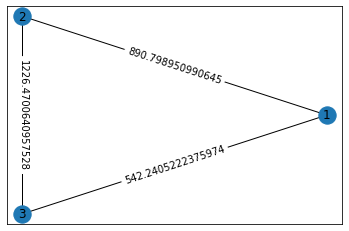

In [16]:
# execute the model and media through the afore-defined function
modelInfo_2 = ['electrosynth_comnty_FullThermo.mdl.gf.2021',93832]
mediaInfo_2 = ["CO2_minimal",93204]
communityFBA(modelInfo_2,mediaInfo_2,2100)

# Brainstorming

In [ ]:
rxn = '123_p0'

if rxn[-1] != '0' and rxn[-1] != 0:
    print(rxn[-1])

In [ ]:
rxn = '123_p1'
compartment_index = rxn.rfind("_")

if (rxn[compartment_index + 1] == 'p' or 'c') and rxn[compartment_index + 2: ] != '0':
    species = rxn[compartment_index + 2:]
    print(species)

In [ ]:
reaction_number = 0
for reaction in model.reactions:
    reaction_number += 1
    
print(reaction_number)